# 🧠 MS Lesion Synthesis Inference Notebook

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import torch
from diffusers import (
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    StableDiffusionInpaintPipeline,
    UNet2DConditionModel,
    DDIMScheduler,
    PNDMScheduler,
    EulerAncestralDiscreteScheduler,
    LCMScheduler)
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor
import pandas as pd


device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 17844

2025-05-23 10:49:12.295172: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-23 10:49:12.318245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747990152.346698 2107403 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747990152.355147 2107403 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747990152.376436 2107403 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
def print_info(var, name):
    print(f"{name}:")
    print(f"  Type: {type(var)}")
    if hasattr(var, 'shape'):
        print(f"  Shape: {var.shape}")
    elif hasattr(var, 'size'):  # for PIL.Image
        print(f"  Size (width, height): {var.size}")
    else:
        print("  No shape or size attribute.")
    print()
    
def load_image(path, size=256, show=True, info=True):
    image = Image.open(path).convert('RGB')
    image = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        # # to tensor
        # transforms.ToTensor(),
    ])(image)

    if show:
        plt.imshow(image)
        plt.title("Loaded image")
        plt.show()
        print(f"Image {path} loaded. Size: {image.size}, mode: {image.mode}")
    
    if info:
        print_info(image, "Image")

    return image


def generate_lesion(pipe, image, mask, prompt, guidance, inference_steps=25, device='cuda', seed=17844, show=True, info=True):
    generator = torch.Generator(device=device).manual_seed(seed)
    result = pipe(prompt=prompt,
                image=image,
                mask_image=mask,
                num_inference_steps=inference_steps,
                generator=generator,
                guidance=guidance, #guidance_scale??
                ).images[0]
    if show:
        plt.imshow(result)
        plt.title("Generated lesion")
        plt.show()

    if info:
        print_info(result, "Generated lesion")
    
    return result


def lesion_difference(original_image, generated_image, mask, show=True, info=True):
    """
    Plot the original image, generated image, their absolute difference,
    and the lesion mask.
    All inputs must be PIL Images or tensors of the same size.
    """
    # Convert images to tensors (C, H, W) normalized to [0,1]
    def to_tensor_if_needed(img):
        return img if isinstance(img, torch.Tensor) else to_tensor(img)

    original_tensor = to_tensor_if_needed(original_image)
    generated_tensor = to_tensor_if_needed(generated_image)
    
    # Compute absolute difference
    diff_tensor = torch.abs(original_tensor - generated_tensor)
    diff_image = diff_tensor.mean(dim=0)  # Grayscale diff for visualization

    # Prepare mask tensor
    mask_tensor = to_tensor_if_needed(mask)
    if mask_tensor.dim() == 3 and mask_tensor.shape[0] == 1:
        mask_tensor = mask_tensor[0]  # Remove channel dim if needed

    # Convert all for imshow (NumPy, H x W or H x W x 3)
    original_np = original_tensor.permute(1, 2, 0).numpy()
    generated_np = generated_tensor.permute(1, 2, 0).numpy()
    diff_np = diff_image.numpy()
    mask_np = mask_tensor.permute(1, 2, 0).numpy() if mask_tensor.dim() == 3 else mask_tensor.numpy()

    if show:
        # Plot
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        
        axs[0].imshow(original_np)
        axs[0].set_title("Original Image")
        axs[0].axis("off")
        
        axs[1].imshow(generated_np)
        axs[1].set_title("Generated Image")
        axs[1].axis("off")
        
        axs[2].imshow(diff_np, cmap='gray')
        axs[2].set_title("Difference Map")
        axs[2].axis("off")
        
        axs[3].imshow(mask_np, cmap='gray')
        axs[3].set_title("Mask")
        axs[3].axis("off")

        plt.suptitle("Original vs Generated Lesion")
        plt.tight_layout()
        plt.show()
    
    diff_max, diff_mean = diff_tensor.max().item(), diff_tensor.mean().item()
    if info:    
        print("Diff max:", diff_max)
        print("Diff mean:", diff_mean)
        
    return diff_tensor, diff_max, diff_mean

def load_inpainting_pipeline(model_id, device):
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float32,
        safety_checker=None,
    )
    pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config) # DDIMScheduler or DPMSolverMultistepScheduler
    pipe.set_progress_bar_config(disable=True)
    return pipe.to(device)

def generate_all_lesions(image_folder, mask_folder, output_root, models, prompt, image_size=512, guidance=1, seed=17844, device='cuda'):
    image_folder = Path(image_folder)
    mask_folder = Path(mask_folder)
    output_root = Path(output_root)
    output_root.mkdir(parents=True, exist_ok=True)

    flair_images = list(image_folder.glob("*.png"))
    print(f"Found {len(flair_images)} FLAIR images to process.")

    for image_path in flair_images:
        base_name = image_path.name
        mask_path = mask_folder / base_name

        if not mask_path.exists():
            print(f"Mask missing for {base_name}, skipping.")
            continue

        image = load_image(str(image_path), image_size, show=False, info=False)
        mask = load_image(str(mask_path), image_size, show=False, info=False)

        for model_name, pipe in models.items():
            out_dir = output_root / model_name
            out_dir.mkdir(parents=True, exist_ok=True)

            result = generate_lesion(pipe, image, mask, prompt, guidance,
                                     inference_steps=25, device=device, seed=seed,
                                     show=False, info=False)

            result.save(out_dir / base_name)
            print(f"Saved lesion for {base_name} in {model_name}")

In [ ]:
pipe_vh = load_inpainting_pipeline("benetraco/ms-lesion-inpainting-vh", device)
pipe_vh_shifts = load_inpainting_pipeline("benetraco/ms-lesion-inpainting-vh-shifts", device)
pipe_vh_shifts_wmh = load_inpainting_pipeline("benetraco/ms-lesion-inpainting-vh-shifts-wmh2017", device)

# pipe_old = load_inpainting_pipeline("../lesion-inpating-dreambooth-model-new", device)
# pipe = load_inpainting_pipeline("../lesion-inpating-dreambooth-model-traintest", device)
# pipe_all = load_inpainting_pipeline("../lesion-inpating-dreambooth-model-traintestall", device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


: 

### Generate synthetic MS lesions for all the test images and models

In [ ]:
# usage
models = {
    "vh": pipe_vh,
    "vh_shifts": pipe_vh_shifts,
    "vh_shifts_wmh": pipe_vh_shifts_wmh
}
image_folder = "./test_images/flair"
mask_folder = "./test_images/synthetic_masks_big"
output_root = "./test_images/generated_lesions_new"
prompt = "MS lesion in an axial FLAIR MRI brain scan."
image_size = 512  # Assumes model was trained at 512x512
guidance = 1

generate_all_lesions(image_folder, mask_folder, output_root, models, prompt,
                      image_size=image_size, guidance=guidance, seed=seed, device=device)

Found 39 FLAIR images to process.
Saved lesion for WMH2017_27_9.png in vh
Saved lesion for WMH2017_27_9.png in vh_shifts
Saved lesion for WMH2017_27_9.png in vh_shifts_wmh
Saved lesion for eval_in_30_12.png in vh
Saved lesion for eval_in_30_12.png in vh_shifts
Saved lesion for eval_in_30_12.png in vh_shifts_wmh
Saved lesion for dev_out_22_7.png in vh
Saved lesion for dev_out_22_7.png in vh_shifts
Saved lesion for dev_out_22_7.png in vh_shifts_wmh
Saved lesion for dev_out_24_4.png in vh
Saved lesion for dev_out_24_4.png in vh_shifts
Saved lesion for dev_out_24_4.png in vh_shifts_wmh
Saved lesion for VH_749_6.png in vh
Saved lesion for VH_749_6.png in vh_shifts
Saved lesion for VH_749_6.png in vh_shifts_wmh
Saved lesion for VH_741_1.png in vh
Saved lesion for VH_741_1.png in vh_shifts
Saved lesion for VH_741_1.png in vh_shifts_wmh
Saved lesion for train_14_5.png in vh
Saved lesion for train_14_5.png in vh_shifts
Saved lesion for train_14_5.png in vh_shifts_wmh
Saved lesion for eval_in_18

: 

### Prova guidance values

In [9]:
from pathlib import Path
import torch
import numpy as np
from PIL import Image
from diffusers import StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler

def load_image(path, size=512):
    image = Image.open(path).convert('RGB')
    image = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        # # to tensor
        # transforms.ToTensor(),
    ])(image)
    return image

def log_validation_by_domain_guidance(
    model_id,
    image_folder,
    mask_folder,
    output_root,
    guidance_values=[1.0],
    image_size=512,
    seed=42,
    device="cuda"
):
    # Load model
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        model_id, torch_dtype=torch.float32, safety_checker=None
    )
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    pipe.to(device).set_progress_bar_config(disable=True)
    generator = torch.Generator(device=device).manual_seed(seed)

    # Paths
    image_folder = Path(image_folder)
    mask_folder = Path(mask_folder)
    output_root = Path(output_root)
    output_root.mkdir(parents=True, exist_ok=True)

    # Prompts
    dataset_prompts = {
        "SHIFTS": "SHIFTS multiple sclerosis lesion in a FLAIR MRI",
        "WMH2017": "WMH2017 multiple sclerosis lesion in a FLAIR MRI",
        "VH": "VH multiple sclerosis lesion in a FLAIR MRI",
    }

    # Iterate over images
    for image_path in sorted(image_folder.glob("*.png")):
        filename = image_path.name.lower()
        mask_path = mask_folder / image_path.name
        if not mask_path.exists():
            continue

        # Detect dataset tag
        if "dev" in filename or "test" in filename or "eval" in filename:
            tag = "SHIFTS"
        elif "wmh2017" in filename:
            tag = "WMH2017"
        elif "vh" in filename:
            tag = "VH"
        else:
            continue

        prompt = dataset_prompts[tag]
        image = load_image(image_path, image_size)
        mask = load_image(mask_path, image_size)

        # Folder for this sample
        sample_dir = output_root / f"{tag}_{image_path.stem}"
        sample_dir.mkdir(parents=True, exist_ok=True)

        # Save input and mask
        image.save(sample_dir / "input.png")
        mask.save(sample_dir / "mask.png")

        # Generate for each guidance value
        for g in guidance_values:
            with torch.autocast(device):
                result = pipe(
                    prompt=prompt,
                    image=image,
                    mask_image=mask,
                    guidance_scale=g,
                    num_inference_steps=25,
                    generator=generator,
                ).images[0]
            result.save(sample_dir / f"{g}.png")

    del pipe
    torch.cuda.empty_cache()
    print(f"Saved all results to {output_root}")


In [ ]:
log_validation_by_domain_guidance(
    model_id="benetraco/ms-lesion-inpainting-vh-shifts-wmh2017_v2",
    image_folder="./test_images/flair",
    mask_folder="./test_images/synthetic_masks_big",
    output_root="./test_images/generated_guidance_effects",
    guidance_values=[0.0, 1.0, 2.0, 3.0, 5.0, 7.5, 10.0],
    image_size=512,
    seed=17844,
    device="cuda"
)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Saved all results to test_images/generated_guidance_effects


: 

### Prova individual

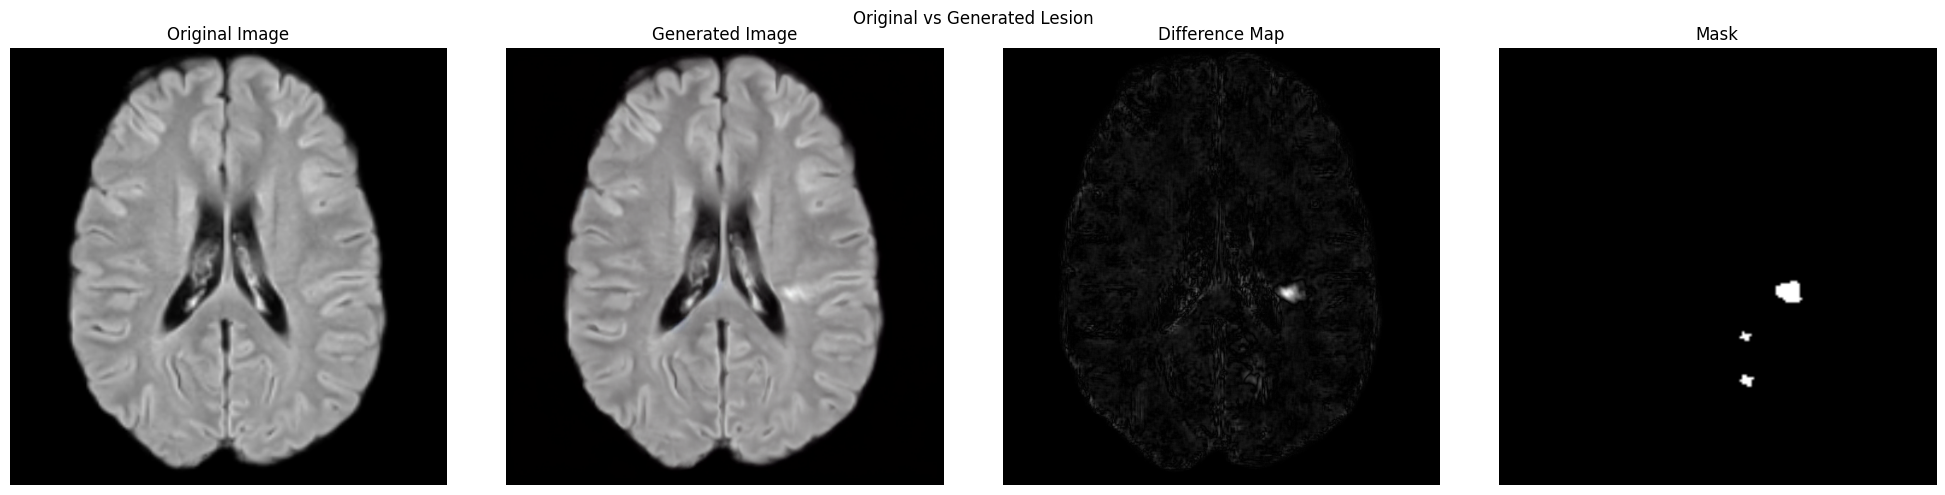

Diff max: 0.3490195870399475
Diff mean: 0.010446510277688503


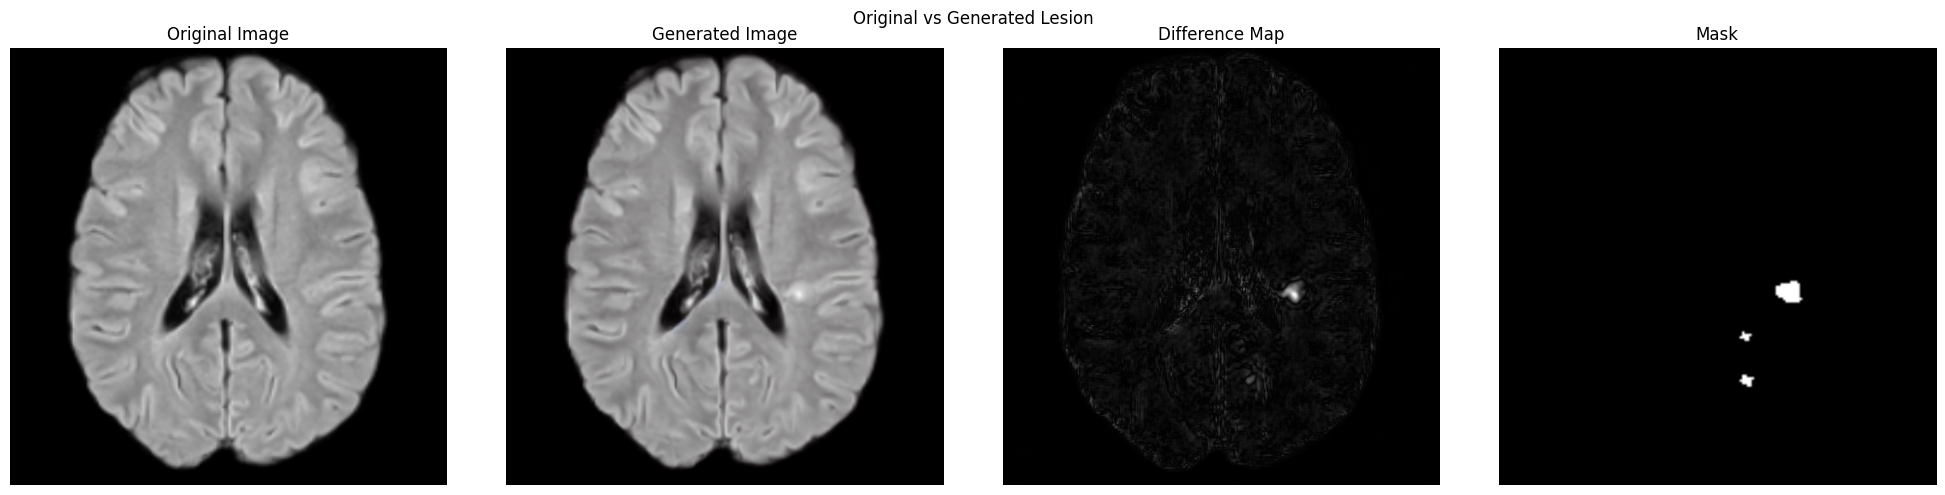

Diff max: 0.32941174507141113
Diff mean: 0.009218577295541763


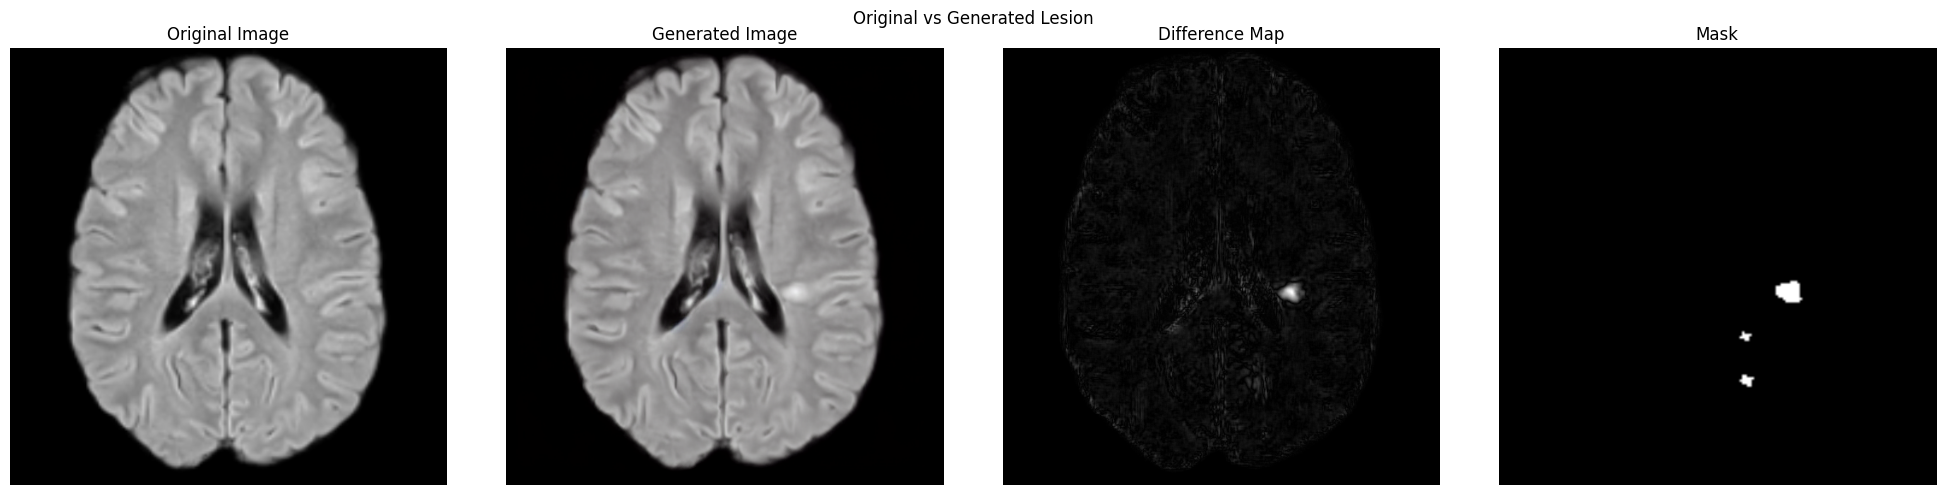

Diff max: 0.3372548818588257
Diff mean: 0.009154350496828556


In [14]:
image_path = "./test_images/flair/VH_738_7.png" # <- Path to the image
mask_path = "./test_images/synthetic_masks/VH_738_7.png" # <- Path to the mask image
prompt = "MS lesion in an axial FLAIR MRI brain scan."           # <- Prompt for the model
image_size = 512  # Assumes model was trained at 512x512
guidance = 1

# Load image and mask
image = load_image(image_path, image_size, show=False, info=False)

# Generate mask
mask = load_image(mask_path, image_size, show=False, info=False)

# Generate lesion
lesion_vh = generate_lesion(pipe_vh, image, mask, prompt, guidance, device=device, show=False, info=False)
lesion_vh_shifts = generate_lesion(pipe_vh_shifts, image, mask, prompt, guidance, device=device, show=False, info=False)
lesion_vh_shifts_wmh = generate_lesion(pipe_vh_shifts_wmh, image, mask, prompt, guidance, device=device, show=False, info=False)

# Plot results
_ = lesion_difference(image, lesion_vh, mask, show=True, info=True)
_ = lesion_difference(image, lesion_vh_shifts, mask, show=True, info=True)
_ = lesion_difference(image, lesion_vh_shifts_wmh, mask, show=True, info=True)